In [78]:
import numpy as np
from keras import datasets, models, layers
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd

# Step 1 : Load and prepare data

In [79]:
# Load the dataframe
df = pd.read_csv('communities.data', header=None)

In [80]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [81]:
sum(df.iloc[:,-1] == '?')

0

We see that there are missing values encoded as '?' in the dataset. However there is no missing value in the target column.

In [82]:
df.describe()

,0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,...,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,118,119,120,125,127
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,28.683551,5.493982,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,0.064072,0.696269,0.361123,0.558154,0.291570,0.495687,0.471133,0.317778,0.479248,0.375677,0.350251,0.368049,0.291098,0.203506,0.322357,0.386279,0.055507,0.303024,0.315807,0.383330,0.361675,0.363531,0.501073,0.396384,0.440597,0.391224,0.441339,0.461244,...,0.150587,0.267608,0.251891,0.462101,0.494428,0.404097,0.562598,0.186264,0.495186,0.314694,0.076815,0.719549,0.548686,0.204529,0.433335,0.494178,0.264478,0.243059,0.264689,0.263490,0.268942,0.346379,0.372457,0.422964,0.384102,0.490125,0.449754,0.403816,0.029438,0.022778,0.215552,0.608892,0.535050,0.626424,0.651530,0.065231,0.232854,0.161685,0.094052,0.237979
std,16.397553,2.873694,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,0.128256,0.444811,0.209362,0.182913,0.204108,0.178071,0.173619,0.222137,0.167564,0.198257,0.191109,0.186804,0.171593,0.164775,0.195411,0.183081,0.127941,0.228474,0.213360,0.202508,0.209193,0.202171,0.174036,0.202386,0.175457,0.198922,0.186292,0.182460,...,0.219716,0.196567,0.190709,0.169551,0.157924,0.189301,0.197087,0.209956,0.172508,0.255182,0.150465,0.194024,0.185204,0.217770,0.188986,0.232467,0.242847,0.206295,0.224425,0.231542,0.235252,0.219323,0.209278,0.248286,0.213404,0.169500,0.187274,0.192593,0.102607,0.100400,0.231134,0.204329,0.181352,0.200521,0.198221,0.109459,0.203092,0.229055,0.240328,0.232985
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,3.000000,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,0.000000,0.000000,0.200000,0.440000,0.160000,0.370000,0.350000,0.142500,0.360000,0.230000,0.220000,0.240000,0.172500,0.110000,0.190000,0.260000,0.010000,0.110000,0.160000,0.230000,0.210000,0.220000,0.380000,0.250000,0.320000,0.240000,0.310000,0.330000,...,0.030000,0.150000,0.140000,0.340000,0.390000,0.270000,0.440000,0.060000,0.400000,0.000000,0.010000,0.630000,0.430000,0.060000,0.290000,0.350000,0.060000,0.100000,0.090000,0.090000,0.090000,0.170000,0.200000,0.220000,0.210000,0.370

We can see that not all the features are scaled so I will have to deal with standardize the data.

In [83]:
sum(df.isna().sum())

0

We can see that there is no Nan encoded values. Let's replace '?' by 0.

In [84]:
# Replace question mark by 0
df.replace(to_replace="?", value = 0, inplace=True)

In [85]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,8,0,0,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,0,0,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.12,0.45,0,0,0,0,0.00,0,0.67
2,24,0,0,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.21,0.02,0,0,0,0,0.00,0,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.39,0.28,0,0,0,0,0.00,0,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.09,0.02,0,0,0,0,0.00,0,0.03


Remove the string encoded features. We can do that safely because we have numeric information about it, such as county numeric state numeric and community numeric

In [86]:
# Remove the city since we have numeric information about it, such as county numeric state numeric and community numeric
df.drop(columns=3, inplace=True)

In [87]:
df.head()

,0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,8,0,0,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,0,0,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.12,0.45,0,0,0,0,0.00,0,0.67
2,24,0,0,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.21,0.02,0,0,0,0,0.00,0,0.43
3,34,5,81440,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.39,0.28,0,0,0,0,0.00,0,0.12
4,42,95,6096,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.09,0.02,0,0,0,0,0.00,0,0.03


In [88]:
# Cast the dataset features in float
df = df.astype('float32')

In [89]:
# Split the data into training and testing sets
train_data = df.iloc[:1400,:-1]
train_target = df.iloc[:1400,-1]
test_data = df.iloc[1400:,:-1]
test_target = df.iloc[1400:,-1]
train_data.shape

(1400, 126)

In [90]:
# Vectorize the data
train_data, test_data, train_target, test_target = train_data.to_numpy() , test_data.to_numpy(), train_target.to_numpy(), test_target.to_numpy()

In [91]:
# Normalize the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [92]:
def load_crime_data() :
  # Load the dataframe
  df = pd.read_csv('communities.data', header=None)
  
  # Replace questions mark by 0
  df.replace(to_replace="?", value = 0, inplace=True)
  
  # Remove the city since we have numeric information about it, such as county numeric state numeric and community numeric
  df.drop(columns=3, inplace=True)
  
  # Cast the data type to float 32
  df = df.astype('float32')
  
  # Split the data into training and testing sets
  train_data = df.iloc[:1400,:-1]
  train_target = df.iloc[:1400,-1]
  test_data = df.iloc[1400:,:-1]
  test_target = df.iloc[1400:,-1]
  
  # Vectorize the data
  train_data, test_data, train_target, test_target = train_data.to_numpy() , test_data.to_numpy(), train_target.to_numpy(), test_target.to_numpy()
  
  # Normalize the data
  mean = train_data.mean(axis=0)
  train_data -= mean
  std = train_data.std(axis=0)
  train_data /= std
  test_data -= mean
  test_data /= std

  return (train_data, train_target) , (test_data, test_target)

In [93]:
(train_data, train_target) , (test_data, test_target) = load_crime_data()

# Step 2 : Build the model

In [94]:
# create the function to be called during K-fold cross validation
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(126,)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
  return model

# Step 3 : Train the model

In [95]:
# Perform 5-fold cross validation
k = 5
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []
all_mae_histories = []

for i in range (k) :
  print('processing fold #', i)

  # Prepare validation fold
  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_target = train_target[i*num_val_samples : (i+1)*num_val_samples]

  # Concatenate training folds
  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples], #everything up to i
       train_data[(i+1)*num_val_samples:]], #everything from i+1
        axis=0)
  
  partial_train_target = np.concatenate(
      [train_target[:i*num_val_samples], #everything up to i
       train_target[(i+1)*num_val_samples:]], #everything from i+1
        axis=0)
  
  # Train using training fold
  model = build_model()
  history = model.fit(partial_train_data, partial_train_target, 
            epochs=num_epochs, batch_size=1, verbose=0) #silent mode

  # Record training performance
  mae = history.history['mae']
  all_mae_histories.append(mae)

  # Record validation performance
  val_mse, val_mae = model.evaluate(val_data, val_target, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [96]:
# compute average per epoch mae score for all folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

[0.22272892892360688,
 0.15779380798339843,
 0.1372203290462494,
 0.12015788406133651,
 0.11098061203956604,
 0.10478086769580841,
 0.09836419075727462,
 0.09481120854616165,
 0.09037266224622727,
 0.08736974895000457,
 0.08536474108695984,
 0.08279383480548859,
 0.07899069637060166,
 0.0781634196639061,
 0.07683722525835038,
 0.07523383647203445,
 0.07309932559728623,
 0.07208793461322785,
 0.07045596241950988,
 0.06791673973202705,
 0.06747388765215874,
 0.0660126805305481,
 0.06510141715407372,
 0.06371745839715004,
 0.06291124895215035,
 0.06080092787742615,
 0.06048722118139267,
 0.05963441804051399,
 0.05890655592083931,
 0.058903641253709796,
 0.05732060447335243,
 0.05679236501455307,
 0.05477408394217491,
 0.05482315346598625,
 0.05441940799355507,
 0.05478639304637909,
 0.054308876395225525,
 0.05258546471595764,
 0.052079258114099504,
 0.0519619308412075,
 0.050956861674785615,
 0.05070272907614708,
 0.0504413940012455,
 0.04967950582504273,
 0.05045574083924294,
 0.04929330

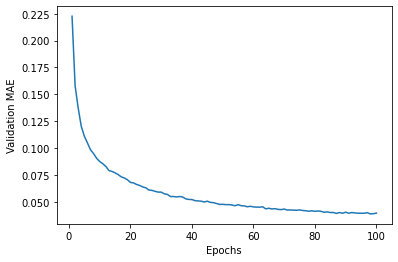

In [97]:
# Plot
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

The model looks good, however it appears that after the 50th the performance stops improving significantly so I will use 50 epochs for the final model.

# Step 4 : Final model and evaluation

In [101]:
# Save the very last one the prediction in the end
inst_data = test_data[-1]
inst_target = test_target[-1]

In [104]:
build_model()
history = model.fit(train_data, train_target, epochs=50, batch_size=1) 

Epoch 1/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0023 - mae: 0.0341
Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0031 - mae: 0.0390
Epoch 3/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0033 - mae: 0.0413
Epoch 4/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0034 - mae: 0.0424
Epoch 5/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0034 - mae: 0.0414
Epoch 6/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0033 - mae: 0.0406
Epoch 7/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0035 - mae: 0.0412
Epoch 8/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0036 - mae: 0.0424
Epoch 9/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0035 - mae: 0.0420
Epoch 10/50
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0036 - mae: 0.0429
Epoch 11/50
1400/1400 [======

In [105]:
# Model evaluation
score = model.evaluate(test_data[:-1], test_target[:-1])
score

19/19 [==============================] - 0s 2ms/step - loss: 0.0261 - mae: 0.1184


[0.026110757142305374, 0.11843056231737137]

In [106]:
model.save("/content/drive/My Drive/Colab Notebooks/CS577_colab/Communities_Crime.h5")

In [107]:
model_loaded = models.load_model("/content/drive/My Drive/Colab Notebooks/CS577_colab/Communities_Crime.h5")

In [108]:
result = model_loaded.predict(inst_data.reshape(1,-1))

In [109]:
result - 0.1184 , result + 0.1184

(array([[0.19665104]], dtype=float32), array([[0.43345106]], dtype=float32))

In [110]:
inst_target

0.48

It works fairly well !